# 🗂️ Dataset Exploration

In this notebook, you can explore the custom CelebA subset we'll use for training all the models in this class. Feel free to play around with it and change it however you'd like.

**Note:** You should be able to use this notebook with CPU only machines.

If you are using VSCode and you do not see your venv in the kernel options, first activate your venv in your terminal and run 

'''

uv run --active python -m ipykernel install --user --name cmu-10799 --display-name "Python (cmu-10799)"

'''

In VS Code:
- Command Palette → Python: Select Interpreter → pick .venv-(your env)/bin/python
- In the notebook → Select Kernel → pick .venv-(your env) or Python (cmu-10799-cpu)

In [4]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Set style
plt.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the Dataset

We use a curated CelebA subset from HuggingFace Hub: `electronickale/cmu-10799-celeba64-subset`

The images are already preprocessed to 64x64 resolution.

In [1]:
from src.data import create_dataloader, unnormalize

# Option 1: Load from local directory (if you've already downloaded)
# First download with: python download_dataset.py --output_dir YOUR_PATH
# Then uncomment the following to use this option:
dataloader = create_dataloader(
    root='../data/celeba-subset/',
    split='train',
    image_size=64,
    batch_size=16,
    num_workers=0,  # Set to 0 for notebooks
    augment=False,  # Disable augmentation for exploration
    from_hub=False,
)

# Option 2: Load directly from HuggingFace Hub (requires 'datasets' package)
# Uncomment the following to use this option:
# dataloader = create_dataloader(
#     split='train',
#     image_size=64,
#     batch_size=64,
#     num_workers=0,
#     augment=False,
#     from_hub=True,
#     repo_name='electronickale/cmu-10799-celeba64-subset',
# )

print(f"Dataset size: {len(dataloader.dataset):,} images")
print(f"Batches: {len(dataloader):,}")

Loaded 63715 images from local directory
Dataset size: 63,715 images
Batches: 3,982


Now it is upon you to decide how you would like to explore the dataset. I would recommend first visualize a grid of samples, and go from there.

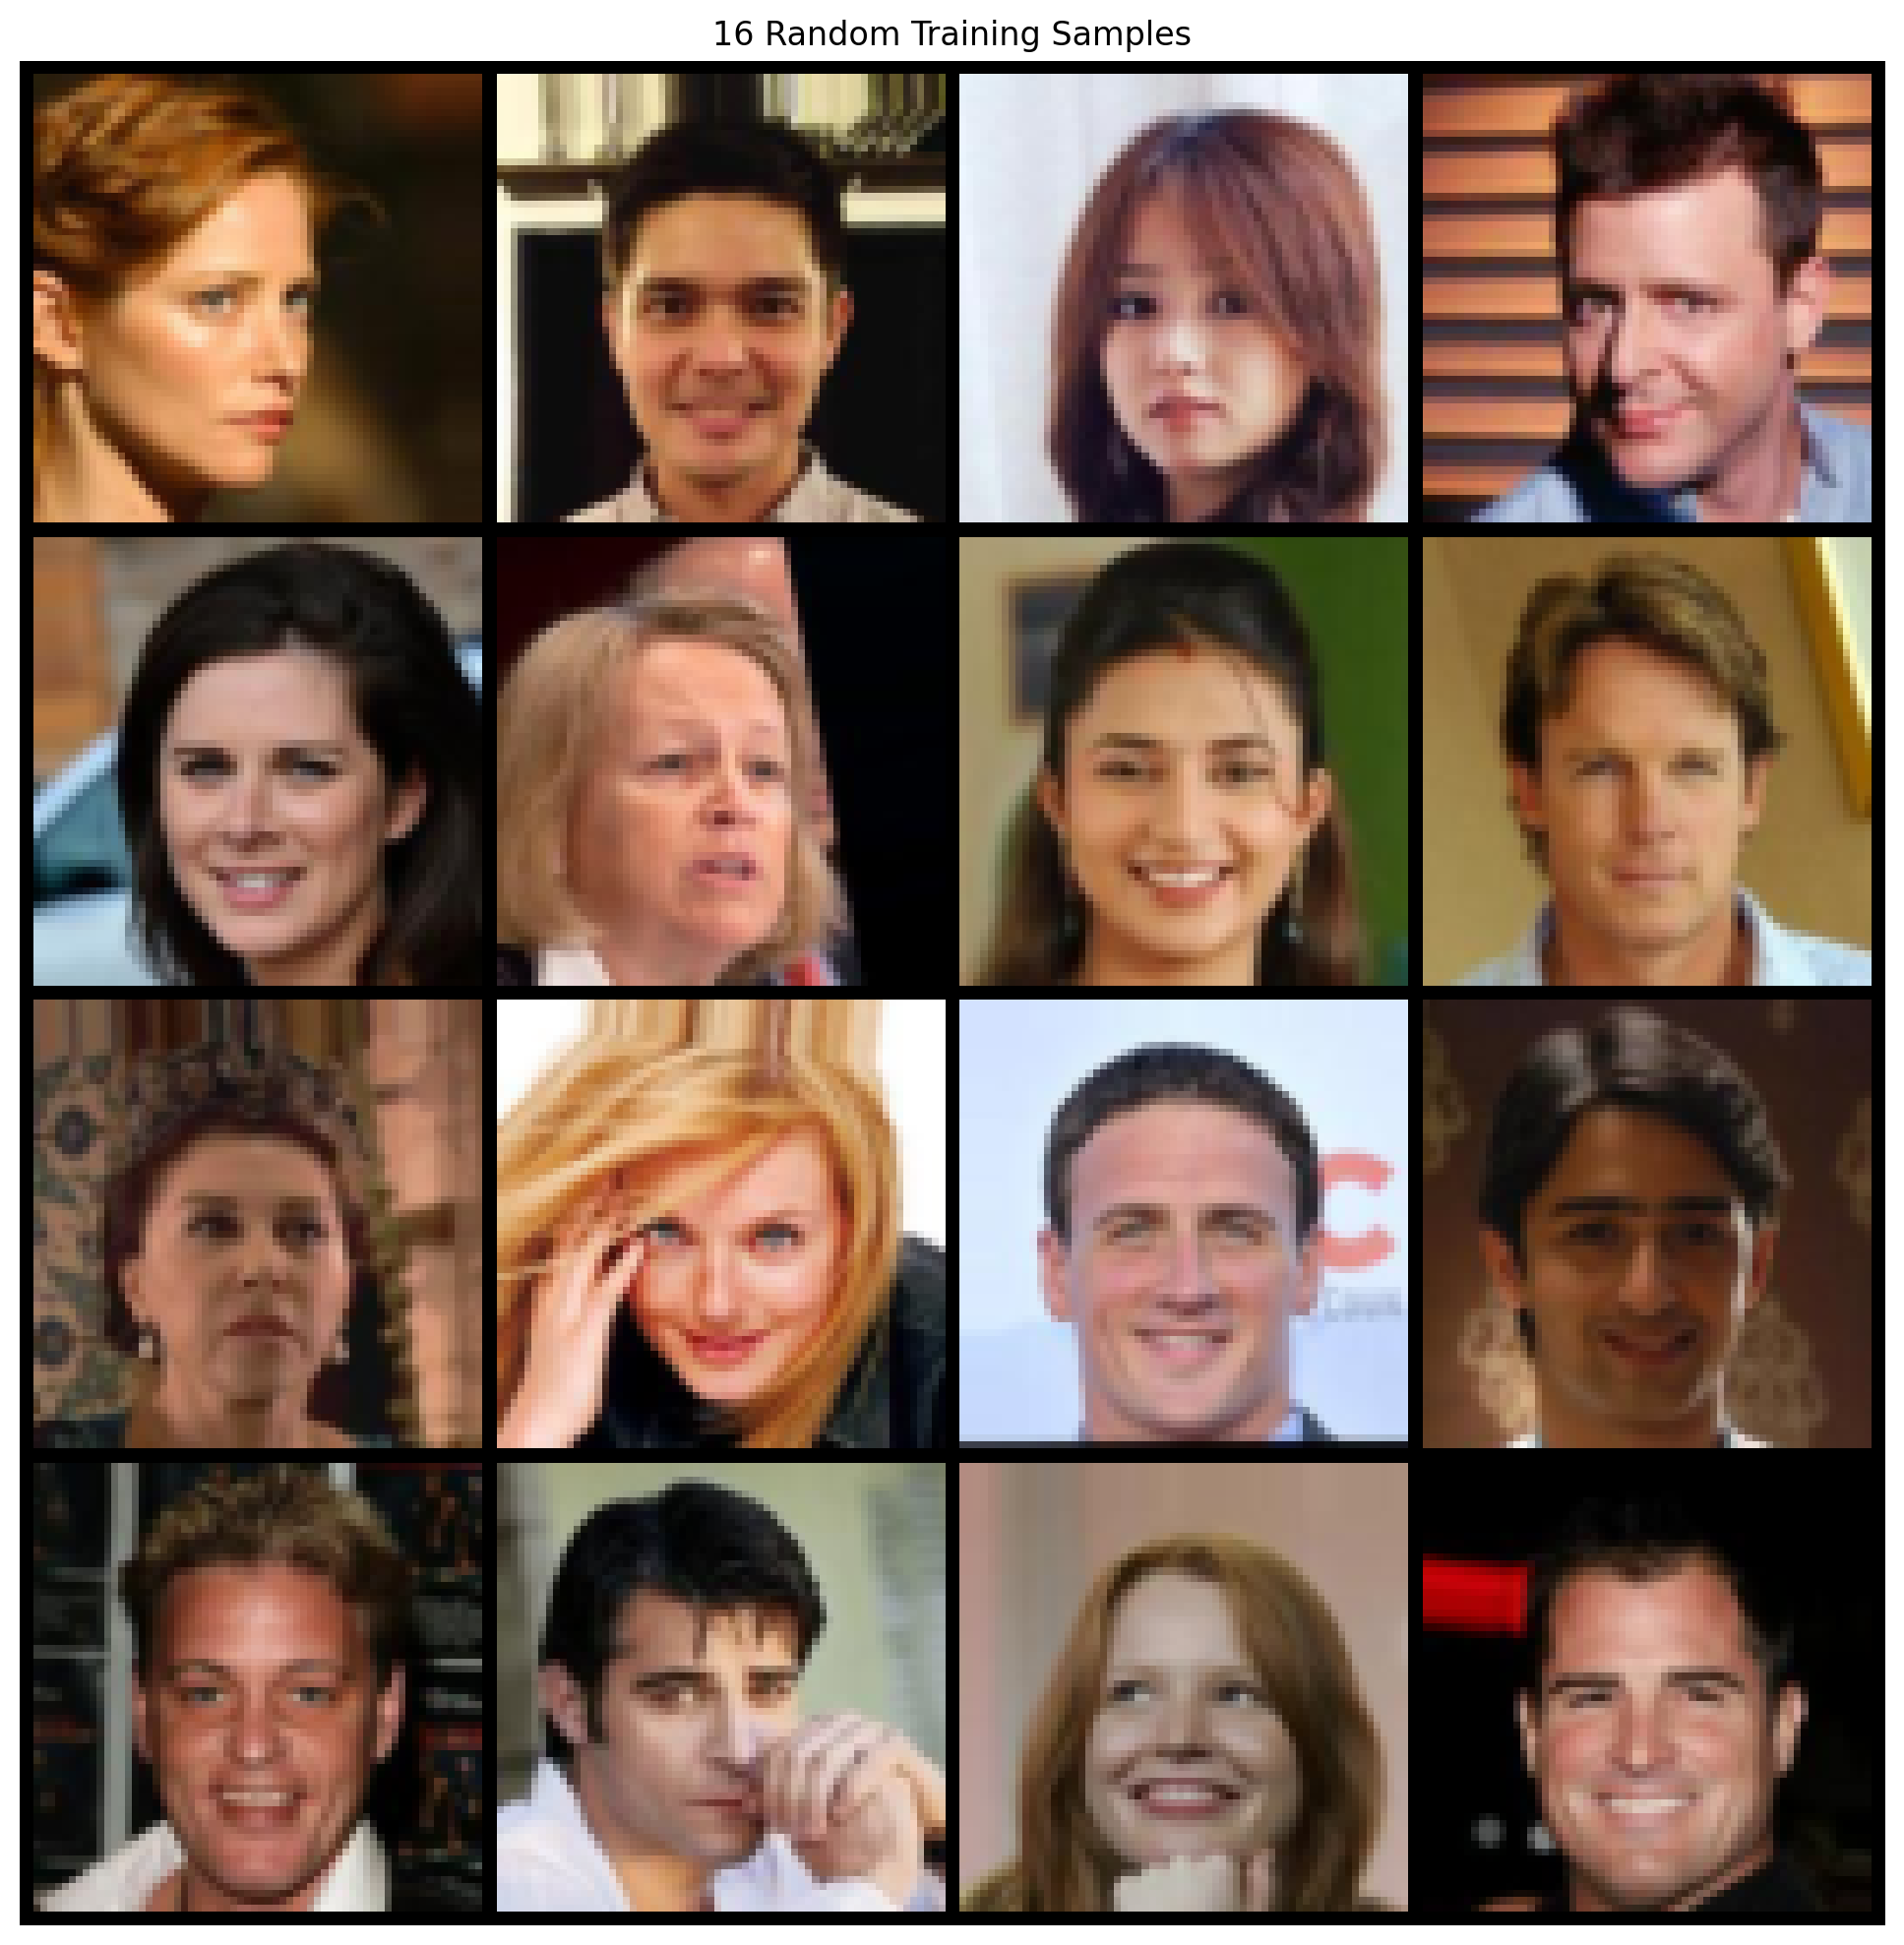

In [5]:
from src.data import unnormalize, make_grid

# Get a batch of images
images = next(iter(dataloader))  # Shape: (16, 3, 64, 64) in range [-1, 1]

# Convert from [-1, 1] to [0, 1] for visualization
images = unnormalize(images)

# Create grid (4 rows x 4 columns)
grid = make_grid(images, nrow=4)

# Convert to numpy and display
grid_np = grid.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(10, 10))
plt.imshow(grid_np)
plt.axis('off')
plt.title('16 Random Training Samples')
plt.tight_layout()
plt.savefig('training_samples_grid.png', dpi=150, bbox_inches='tight')
plt.show()

Attribute Distribution Analysis

Total samples: 63,715

Attributes sorted by percentage of '1' values:
--------------------------------------------------------------------------------
Attribute                      % = 1      % = 0      Count = 1    Count = 0   
--------------------------------------------------------------------------------
Blurry                           0.00%   100.00%            0       63,715
Eyeglasses                       0.00%   100.00%            0       63,715
Heavy_Makeup                     0.00%   100.00%            0       63,715
Wearing_Hat                      0.00%   100.00%            0       63,715
Sideburns                        0.13%    99.87%           81       63,634
Mustache                         0.18%    99.82%          117       63,598
Goatee                           0.25%    99.75%          159       63,556
Rosy_Cheeks                      0.89%    99.11%          564       63,151
Bald                             2.46%    97.54%        

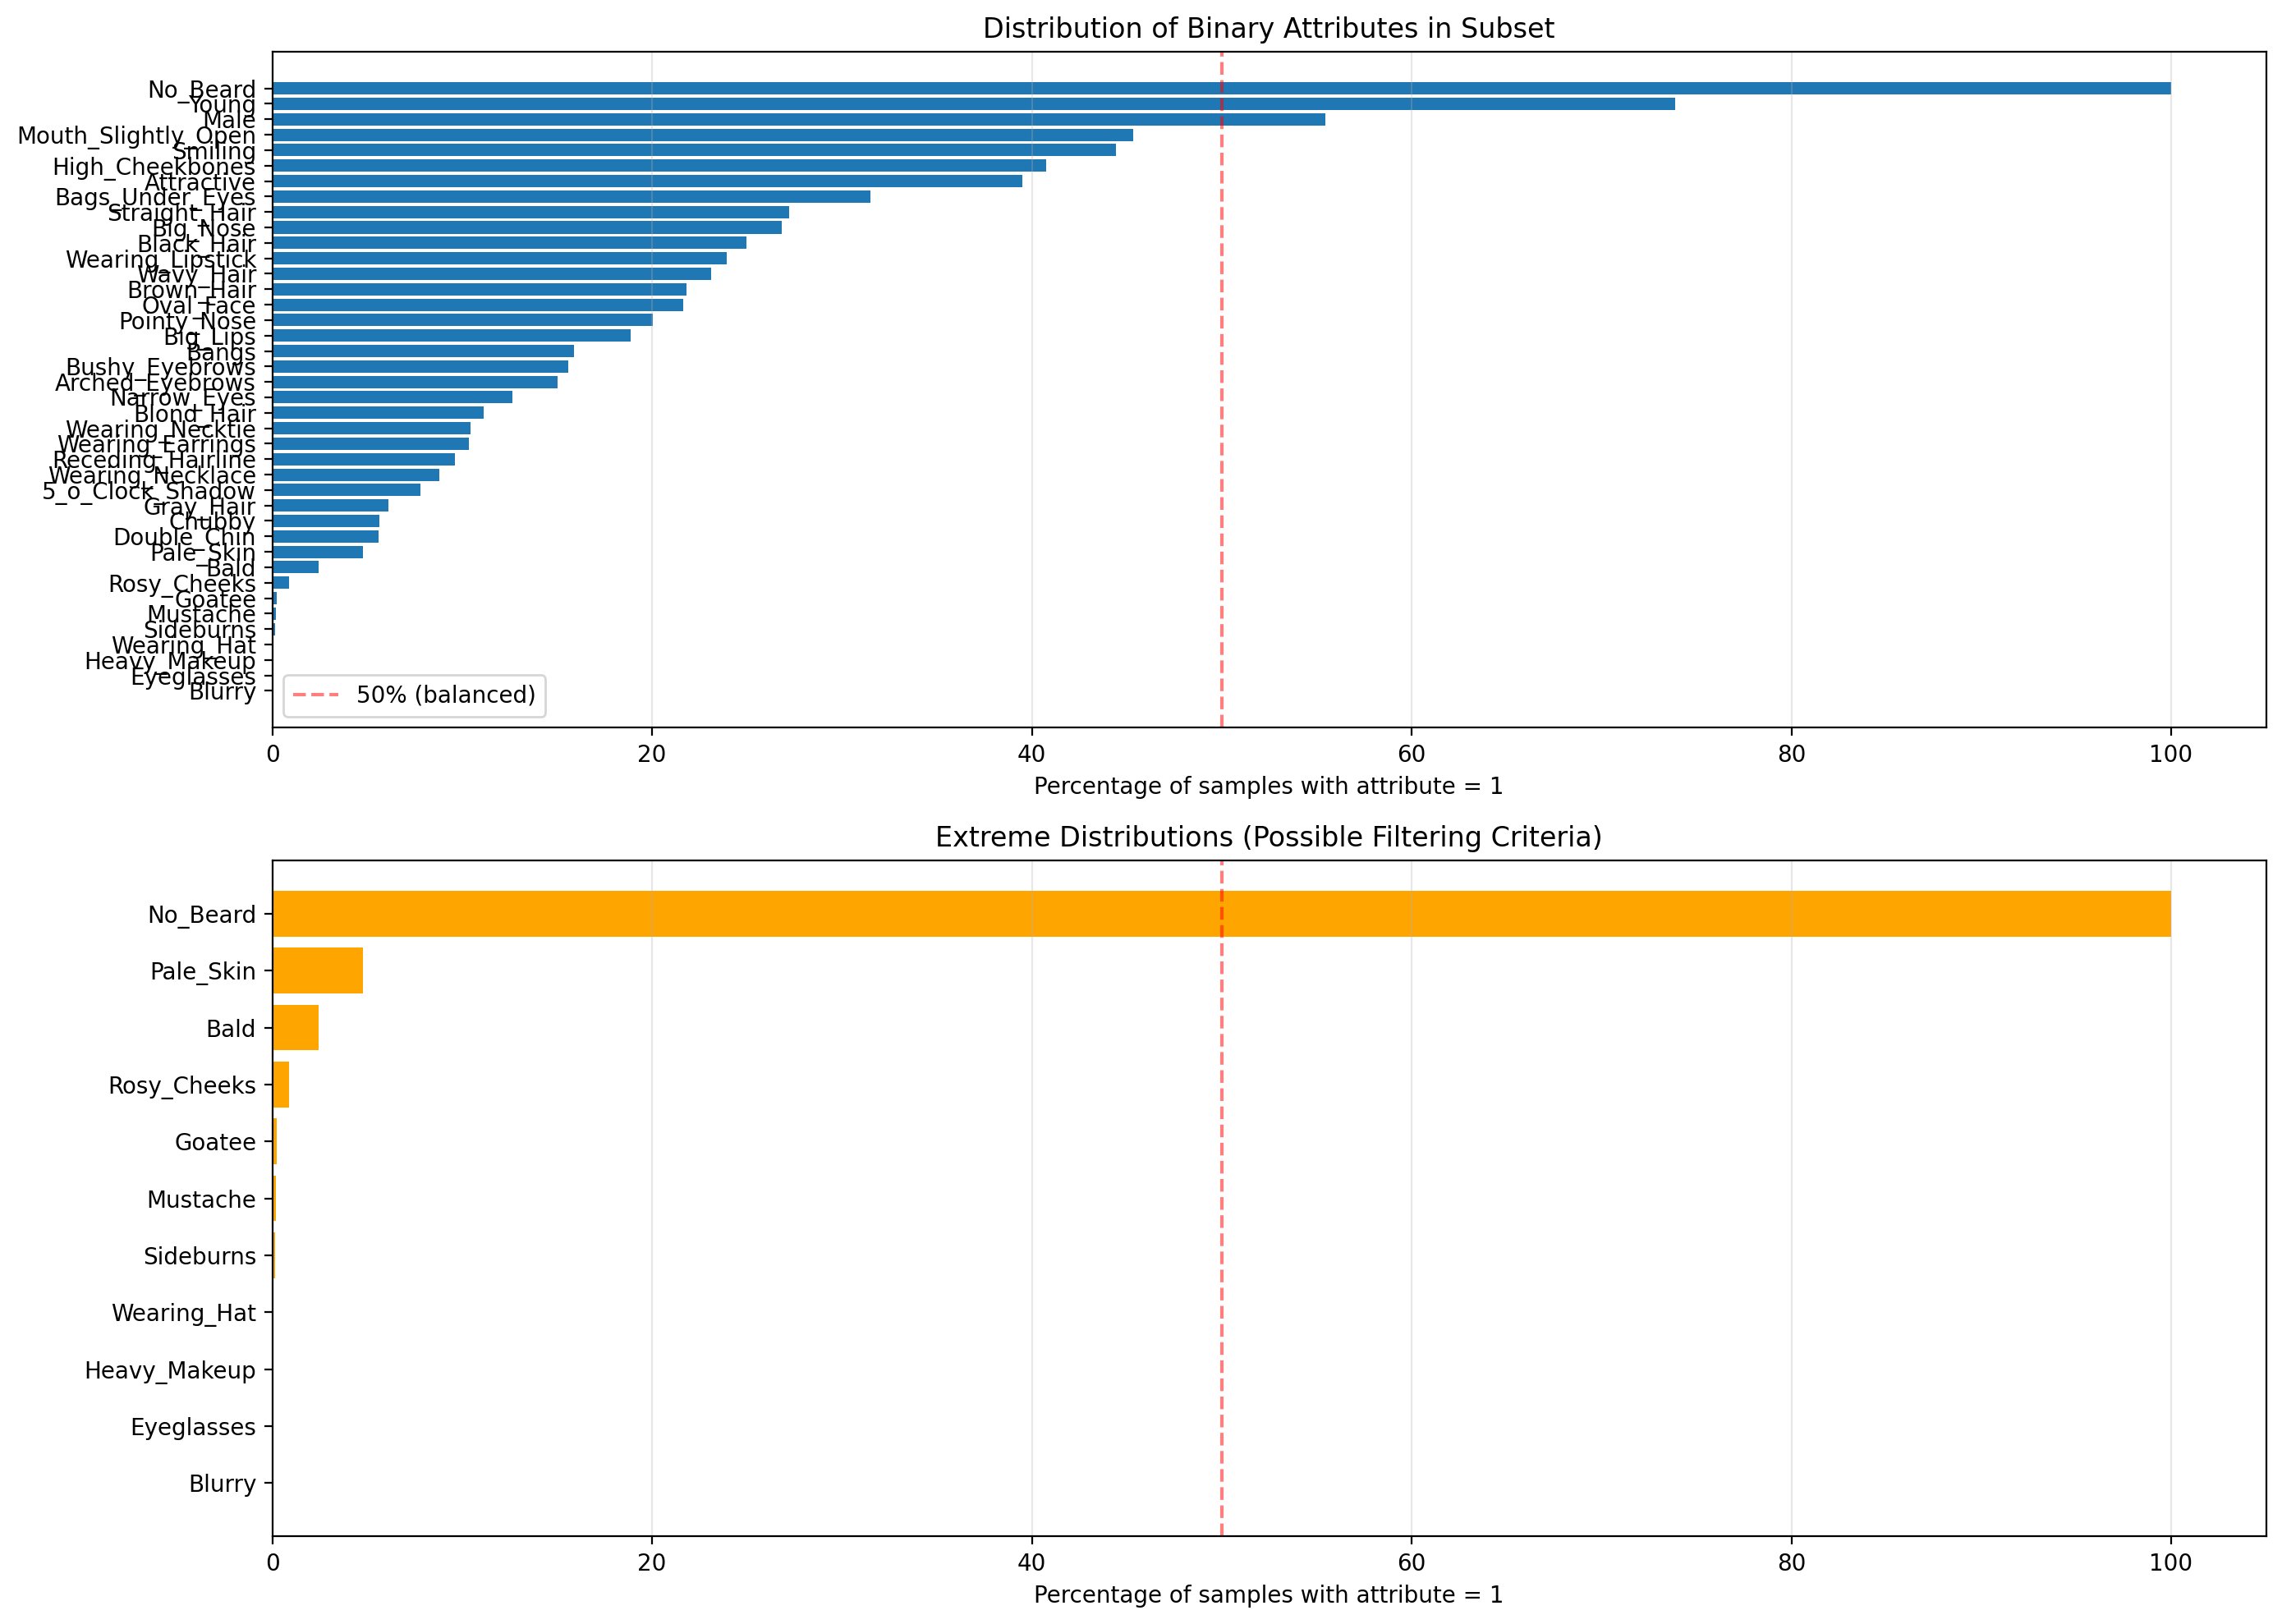


Additional Insights:

Checking for patterns...
Total samples: 63,715


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the attributes CSV
attributes_path = '../data/celeba-subset/train/attributes.csv'
df = pd.read_csv(attributes_path, index_col='image_id')

# Calculate the percentage of each attribute being 1 (present)
attribute_stats = {}
for col in df.columns:
    pct_1 = df[col].mean() * 100  # Percentage where attribute is 1
    attribute_stats[col] = {
        'pct_1': pct_1,
        'pct_0': 100 - pct_1,
        'count_1': df[col].sum(),
        'count_0': len(df) - df[col].sum(),
        'total': len(df)
    }

# Sort by percentage
sorted_stats = sorted(attribute_stats.items(), key=lambda x: x[1]['pct_1'])

# Print statistics
print("=" * 80)
print("Attribute Distribution Analysis")
print("=" * 80)
print(f"\nTotal samples: {len(df):,}")
print("\nAttributes sorted by percentage of '1' values:")
print("-" * 80)
print(f"{'Attribute':<30} {'% = 1':<10} {'% = 0':<10} {'Count = 1':<12} {'Count = 0':<12}")
print("-" * 80)

for attr, stats in sorted_stats:
    print(f"{attr:<30} {stats['pct_1']:>6.2f}%   {stats['pct_0']:>6.2f}%   {stats['count_1']:>10,}   {stats['count_0']:>10,}")

# Visualize distributions
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Bar plot of percentages
attrs = [x[0] for x in sorted_stats]
pcts = [x[1]['pct_1'] for x in sorted_stats]

axes[0].barh(attrs, pcts)
axes[0].set_xlabel('Percentage of samples with attribute = 1')
axes[0].set_title('Distribution of Binary Attributes in Subset')
axes[0].axvline(x=50, color='r', linestyle='--', alpha=0.5, label='50% (balanced)')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Look for extreme distributions (likely filtering criteria)
extreme_attrs = []
for attr, stats in attribute_stats.items():
    pct = stats['pct_1']
    # Attributes that are almost always 0 or almost always 1 might indicate filtering
    if pct < 5 or pct > 95:
        extreme_attrs.append((attr, pct))

if extreme_attrs:
    print("\n" + "=" * 80)
    print("EXTREME DISTRIBUTIONS (Possible Filtering Criteria):")
    print("=" * 80)
    for attr, pct in sorted(extreme_attrs, key=lambda x: x[1]):
        print(f"{attr:<30} {pct:>6.2f}% are 1")
    
    # Plot extreme attributes
    extreme_attrs_sorted = sorted(extreme_attrs, key=lambda x: x[1])
    axes[1].barh([x[0] for x in extreme_attrs_sorted], 
                 [x[1] for x in extreme_attrs_sorted], 
                 color='orange')
    axes[1].set_xlabel('Percentage of samples with attribute = 1')
    axes[1].set_title('Extreme Distributions (Possible Filtering Criteria)')
    axes[1].axvline(x=50, color='r', linestyle='--', alpha=0.5)
    axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('attribute_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Additional analysis: check for combinations
print("\n" + "=" * 80)
print("Additional Insights:")
print("=" * 80)

# Check if certain attributes are mutually exclusive or always co-occur
print("\nChecking for patterns...")
print(f"Total samples: {len(df):,}")